**STUDENT**:  Amine Kheldouni

**EMAIL**:  mkheldou@ens-paris-saclay.fr

# Image Classification and Regression 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras.utils as np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, UpSampling2D, Activation
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
IMAGE_SIZE = 72
%matplotlib inline


Using TensorFlow backend.


## 3 - Simple Classification

In [0]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


In [0]:

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data..')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    print('Data created successfully !')
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [0]:

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data..')
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    print('Data created successfully !')
    return [X, Y]

import matplotlib.patches as patches

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [0]:

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

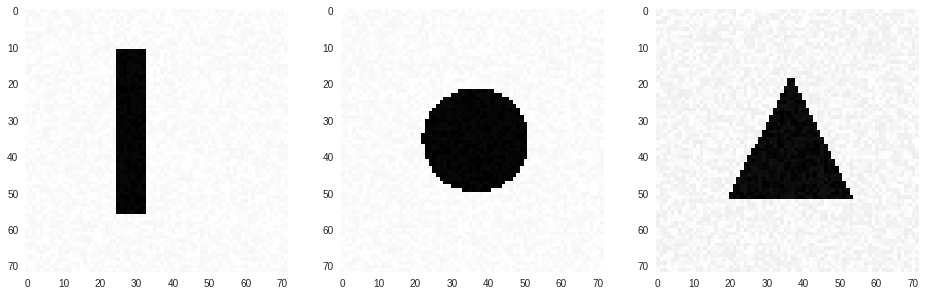

In [8]:
def plot_examples():
  fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 16))
  im = generate_a_rectangle(10, True)
  ax1.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
  ax1.grid(None)

  im = generate_a_disk(10)
  ax2.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
  ax2.grid(None)

  [im, v] = generate_a_triangle(20, False)
  ax3.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
  ax3.grid(None)
  plt.show()
  
plot_examples()

In [9]:
# Generating the training dataset
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data..
Data created successfully !


In [0]:
def linear_shape_classifier(X, Y, optimizer='adam', logs=2):
  Y_categorical = to_categorical(Y, num_classes=3)
  
  model = Sequential()
  model.add(Dense(3, input_dim=5184, activation='softmax'))


  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  history = model.fit(X, Y_categorical, validation_split=0.1, epochs=100, batch_size=8, verbose=logs, shuffle=True)
  return history, model

history_sgd, model_sgd = linear_shape_classifier(X_train, Y_train, SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True), logs=0)
history_adam, model_adam = linear_shape_classifier(X_train, Y_train, 'adam', logs=0)


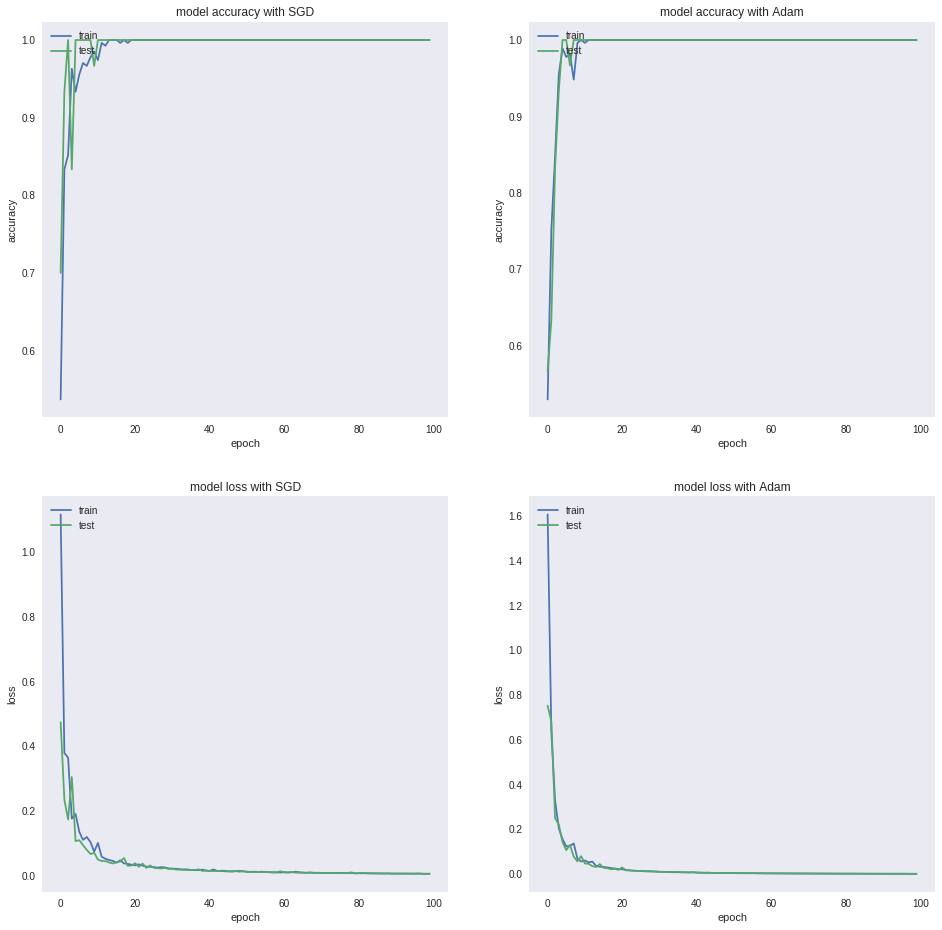

In [11]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(16, 16))
ax1.plot(history_sgd.history['acc'])
ax1.plot(history_sgd.history['val_acc'])
ax1.set_title('model accuracy with SGD')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.grid(None)
ax1.legend(['train', 'test'], loc='upper left')

ax2.plot(history_adam.history['acc'])
ax2.plot(history_adam.history['val_acc'])
ax2.set_title('model accuracy with Adam')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.grid(None)
ax2.legend(['train', 'test'], loc='upper left')

ax3.plot(history_sgd.history['loss'])
ax3.plot(history_sgd.history['val_loss'])
ax3.set_title('model loss with SGD')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.grid(None)
ax3.legend(['train', 'test'], loc='upper left')

ax4.plot(history_adam.history['loss'])
ax4.plot(history_adam.history['val_loss'])
ax4.set_title('model loss with Adam')
ax4.set_ylabel('loss')
ax4.set_xlabel('epoch')
ax4.grid(None)
ax4.legend(['train', 'test'], loc='upper left')
plt.show()


### Comments

Our linear neural network classifier manages to classify the shapes in the three categories pretty well. Indeed, the training and validation losses both converge to 0 after 100 epochs and the accuracy is appropriate and acceptable.

However, as we can see in the above figures, the SGD optimizer has more difficulty than the Adam optimizer while minimizing the categorical cross-entropy. SGD needs more than 20 epochs to get a loss close to 0 whereas Adam converges faster. Moreover, we performed some parameters tuning on SGD to get a more stable convergence.

In [12]:
# Checking the Linear classifier model
X_test = generate_a_disk()
X_test = X_test.reshape(1,-1)
print("Predicted label for a disk: ", model_adam.predict(X_test))

X_test = generate_a_rectangle()
X_test = X_test.reshape(1,-1)
print("Predicted label for a rectangle: ", model_adam.predict(X_test))

X_test, _ = generate_a_triangle()
X_test = X_test.reshape(1,-1)
print("Predicted label for a triangle: ", model_adam.predict(X_test))

Predicted label for a disk:  [[0. 1. 0.]]
Predicted label for a rectangle:  [[1. 0. 0.]]
Predicted label for a triangle:  [[0. 0. 1.]]


## 4 - Visualization of the Solution

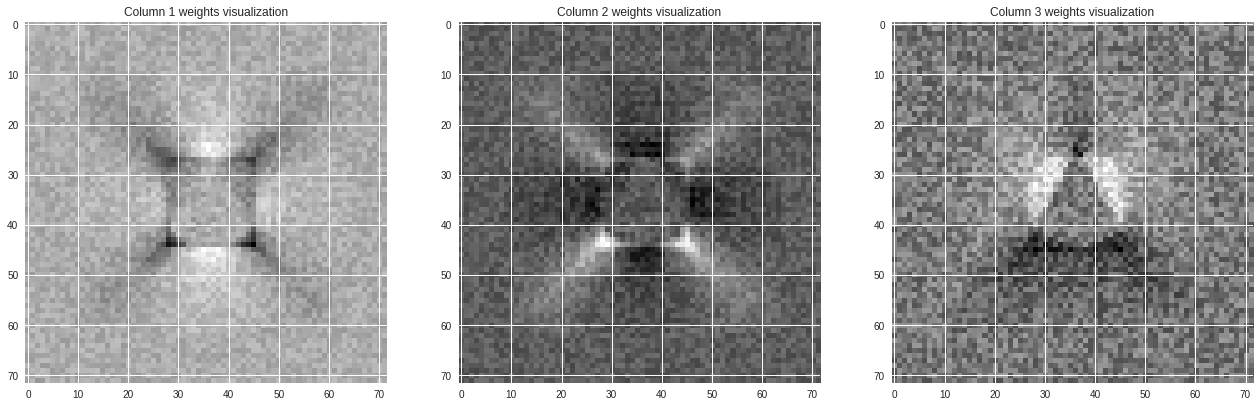

In [13]:
fig, ax = plt.subplots(1,3,figsize=(22,22))
for j in range(3):
  ax[j].imshow(model_adam.get_weights()[0][:,j].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
  ax[j].set_title("Column " + str(j+1) + " weights visualization")
plt.show()

### Comments

Each column corresponds to on of our three classes (rectangles, circles, triangles). When looking at the weights' visualization, we acknowledge the fact that the linear network learns the rectangle shape by detecting its four edges (black areas). It detects the circles by not finding its edges (white areas). And it detects triangles by find three edges and no rectangle-like edges (four symmetric edges).

## 5 - A More Difficult Classification Problem

In [14]:
# Generating the data
nb_sample = 2000
[X_train, Y_train] = generate_dataset_classification(nb_sample, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating data..
Data created successfully !
Creating data..
Data created successfully !


In [0]:
history_adam, model_adam = linear_shape_classifier(X_train, Y_train, 'adam', logs=0)

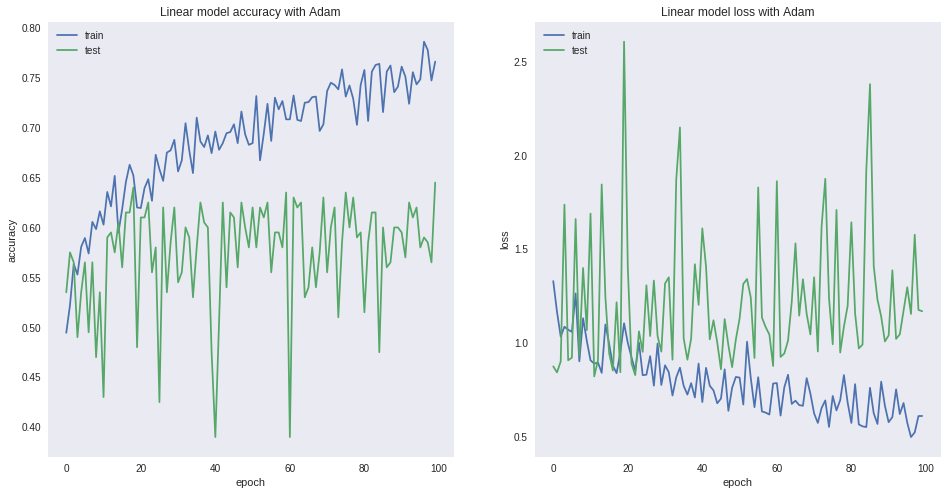

300/300 [==============================] - 0s 128us/step
Cross-entropy loss for test dataset:  1.0174494886398315
Accuracy for test dataset:  0.6233333341280619


In [16]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(history_adam.history['acc'])
ax1.plot(history_adam.history['val_acc'])
ax1.set_title('Linear model accuracy with Adam')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.grid(None)
ax1.legend(['train', 'test'], loc='upper left')

ax2.plot(history_adam.history['loss'])
ax2.plot(history_adam.history['val_loss'])
ax2.set_title('Linear model loss with Adam')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.grid(None)
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

[test_loss, test_accuracy] =  model_adam.evaluate(X_test, Y_test)
print("Cross-entropy loss for test dataset: ",test_loss)
print("Accuracy for test dataset: ",test_accuracy)


### Comments

Our linear classifier network performs well on the training dataset, but performs poorly on the test dataset. Therefore, we need to use deeper networks (with higher parameter levels) to avoid fitting the training dataset without achieving a low loss value, and failing to generalize the prediction to new datasets because of a lack of explanatory parameters (underfitting the model).

In [0]:

def cnn_classifier(X, Y):
    Y_categorical = np_utils.to_categorical(Y, num_classes=3)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    X = X.reshape((2000,IMAGE_SIZE,IMAGE_SIZE,1))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X, Y_categorical, validation_split=0.1, epochs=10, batch_size=32, verbose=2)
    
    return history, model
  
cnn_history, cnn_model = cnn_classifier(X_train, Y_train)

Train on 1800 samples, validate on 200 samples
Epoch 1/10
 - 49s - loss: 1.7731 - acc: 0.5261 - val_loss: 0.6700 - val_acc: 0.7100
Epoch 2/10
 - 48s - loss: 0.5207 - acc: 0.8100 - val_loss: 0.3647 - val_acc: 0.8950
Epoch 3/10
 - 48s - loss: 0.2970 - acc: 0.9006 - val_loss: 0.2346 - val_acc: 0.9100
Epoch 4/10
 - 48s - loss: 0.1363 - acc: 0.9578 - val_loss: 0.1526 - val_acc: 0.9550
Epoch 5/10
 - 48s - loss: 0.0648 - acc: 0.9817 - val_loss: 0.1448 - val_acc: 0.9550
Epoch 6/10
 - 48s - loss: 0.0358 - acc: 0.9917 - val_loss: 0.1586 - val_acc: 0.9550
Epoch 7/10
 - 48s - loss: 0.0260 - acc: 0.9917 - val_loss: 0.1355 - val_acc: 0.9500
Epoch 8/10
 - 48s - loss: 0.0198 - acc: 0.9956 - val_loss: 0.1448 - val_acc: 0.9550
Epoch 9/10
 - 48s - loss: 0.0154 - acc: 0.9972 - val_loss: 0.1528 - val_acc: 0.9450
Epoch 10/10
 - 48s - loss: 0.0088 - acc: 0.9989 - val_loss: 0.1576 - val_acc: 0.9500


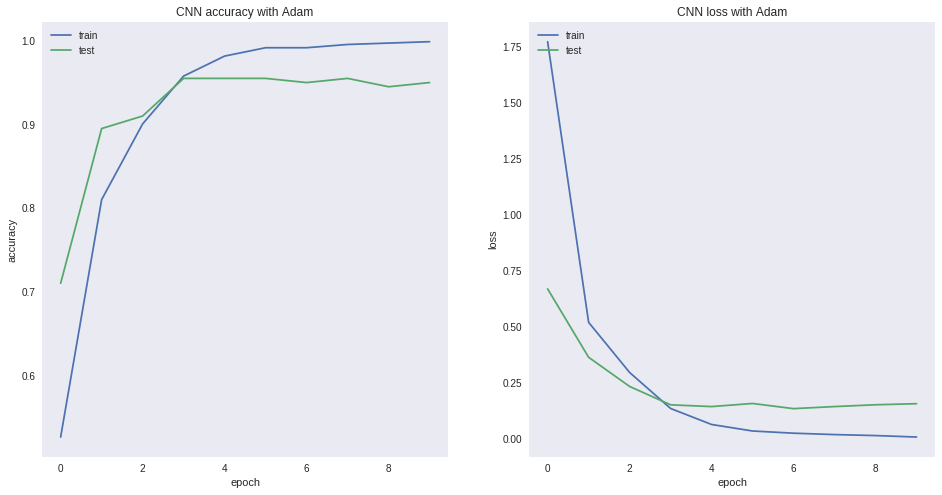

300/300 [==============================] - 1s 5ms/step
Cross-entropy loss for test dataset:  0.17227073748906455
Accuracy for test dataset:  0.9500000007947286


In [0]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(cnn_history.history['acc'])
ax1.plot(cnn_history.history['val_acc'])
ax1.set_title('CNN accuracy with Adam')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.grid(None)
ax1.legend(['train', 'test'], loc='upper left')

ax2.plot(cnn_history.history['loss'])
ax2.plot(cnn_history.history['val_loss'])
ax2.set_title('CNN loss with Adam')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.grid(None)
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

X_test = X_test.reshape((300, IMAGE_SIZE, IMAGE_SIZE, 1))
[test_loss, test_accuracy] =  cnn_model.evaluate(X_test, Y_test)
print("Cross-entropy loss for test dataset: ",test_loss)
print("Accuracy for test dataset: ",test_accuracy)

### Comments

The linear classifier we built during previous sections performs poorly with the new dataset (move within the images and change dimensions). Indeed, the accuracy of the linear model was of 61% on the test set. The model was obviously underfitting the problem since it does not integrate enough complexity and parameters to explain and predict the shapes in an accurate way.

Increasing our dataset to 2000 training dataset (of which we take 10% for the validation), we model the classification with a deeper neural network (Convolutional Neural Network). This approach allows us to converge with only 10 epochs to a much higher accuracy for both training and testing datasets, with a loss converging to small values. 
Finally, we achieve a performance of 99.89% on the training set and 95% on the test set !


## 6 - A Regression Problem

In [17]:
nb_samples = 2500
[X_train, Y_train] = generate_dataset_regression(nb_samples, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data..
Data created successfully !
Creating data..
Data created successfully !


Example of Ground Truth triangle edges detection


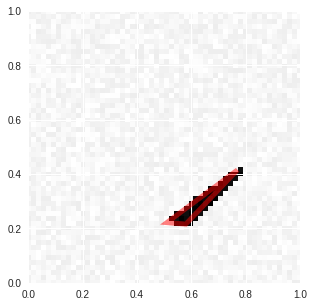

In [18]:
print("Example of Ground Truth triangle edges detection")
visualize_prediction(X_train[0], Y_train[0])

In [0]:
def order(y):
  theta1 = np.arctan(y[1]/y[0])
  theta2 = np.arctan(y[3]/y[2])
  theta3 = np.arctan(y[5]/y[4])
  angles = [theta1, theta2, theta3]
  listX = [y[0], y[2], y[4]]
  listY = [y[1], y[3], y[5]]
  idx = np.argsort(angles)
  result = []
  for i in idx:
    result.append(listX[i])
    result.append(listY[i])
  return result

for i in range(len(Y_train)):
  Y_train[i] = order(Y_train[i])
for i in range(len(Y_test)):
  Y_test[i] = order(Y_test[i])

In [0]:

def cnn_regressor(X, Y):
  model = Sequential()
  
  model.add(Conv2D(24, (7, 7), padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(24, (7, 7), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(24, (7, 7), padding='same', activation='relu'))
  
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(6, activation='relu'))
  
  model.compile(loss='mse', optimizer='adam')
  X = X.reshape((nb_samples, IMAGE_SIZE, IMAGE_SIZE,1))
  hist = model.fit(X, Y, validation_split=0.1, epochs=30, batch_size=32, verbose=0, shuffle=True)
  
  return hist, model

regression_history, regression_model = cnn_regressor(X_train, Y_train)

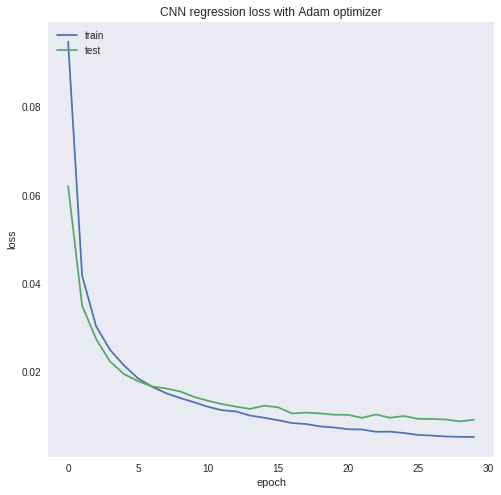

300/300 [==============================] - 2s 6ms/step
Cross-entropy loss for test dataset:  0.008480469702432552


In [22]:
plt.figure(figsize=(8,8))
plt.plot(regression_history.history['loss'])
plt.plot(regression_history.history['val_loss'])
plt.title('CNN regression loss with Adam optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(None)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

X_test = X_test.reshape((300, IMAGE_SIZE, IMAGE_SIZE, 1))
test_loss =  regression_model.evaluate(X_test, Y_test)
print("Cross-entropy loss for test dataset: ",test_loss)


Displaying some prediction examples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in float_scalars
  after removing the cwd from sys.path.


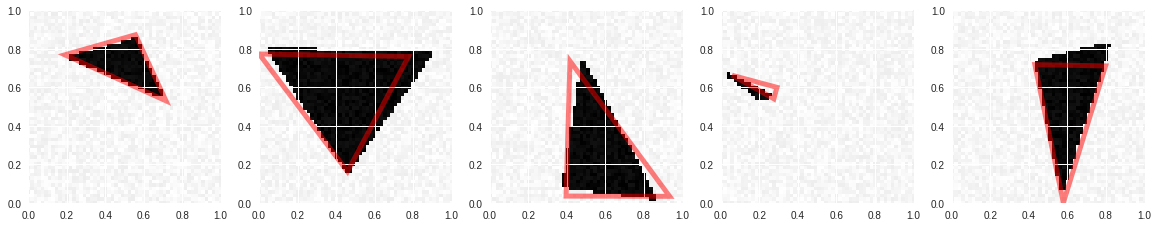

In [29]:
print("Displaying some prediction examples")
fig, ax = plt.subplots(1,5,figsize=(20,60))
Y = regression_model.predict(X_test)
for j in range(5):
  rd = np.random.randint(X_test.shape[0])
  I = X_test[rd].reshape((IMAGE_SIZE,IMAGE_SIZE))
  ax[j].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
  ax[j].set_xlim([0,1])
  ax[j].set_ylim([0,1])
  xy = np.array(order(Y[rd])).reshape(3,2)
  tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
  ax[j].add_patch(tri)

plt.show()

### Comments

We manage to build a successfull triangle edges regressor. In average, the results of such a regressor are coherent with the shape of the given triangle. As a pre-processing step, we had to reorder the 3 edges of each triangle by trigonometric order to enforce the networks' learning.

However, we notice that the green curve (validation loss) decreases until a certain threshold $\gamma$ and stops decreasing after 3 or 4 epochs. This may be an overfitting of the training dataset, which can explain some mis-detections in triangles' edges on the test dataset.

## 7 - Image Denoising

In [0]:
def generate_a_rectangle(free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, np.random.randint(-600, 600)), generate_a_drawing(figsize, U, V, 0)


def generate_a_disk(free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, np.random.randint(-600, 600)), generate_a_drawing(figsize, U, V, 0)

def generate_a_triangle(free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, np.random.randint(-600, 600))
    imdata2 = generate_a_drawing(figsize, U, V, 0)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]],[imdata2, [U[0], V[0], U[1], V[1], U[2], V[2]]]
  
  
def generate_noisy_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data..')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            Y[i],X[i] = generate_a_rectangle(free_location)
        elif category == 1: 
            Y[i],X[i] = generate_a_disk(free_location)
        else:
            [Y[i], Vy], [X[i], V] = generate_a_triangle(free_location)
    X = (X + noise) / (255 + 2 * noise)
    print('Data created successfully !')
    return [X, Y]


In [31]:
X_train, X_train_noisy = generate_noisy_dataset_classification(1000)
X_test, X_test_noisy = generate_noisy_dataset_classification(300)

Creating data..
Data created successfully !
Creating data..
Data created successfully !


In [0]:
X_train = X_train.reshape((len(X_train), IMAGE_SIZE, IMAGE_SIZE, 1)) 
X_test = X_test.reshape((len(X_test), IMAGE_SIZE, IMAGE_SIZE, 1))  
X_train_noisy = X_train_noisy.reshape((len(X_train), IMAGE_SIZE, IMAGE_SIZE, 1)) 
X_test_noisy = X_test_noisy.reshape((len(X_test), IMAGE_SIZE, IMAGE_SIZE, 1))  

7 examples of noisy shapes from the test dataset


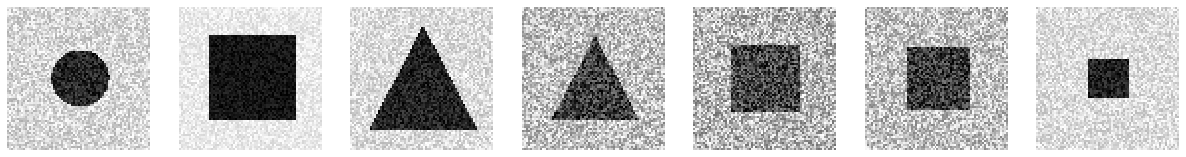

In [33]:
print("7 examples of noisy shapes from the test dataset")
n = 7
plt.figure(figsize=(21, 21))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test_noisy[np.random.randint(len(X_test_noisy))].reshape(IMAGE_SIZE, IMAGE_SIZE))
    plt.grid(None)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
def denoising_encoder(X, X_noisy):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  
  model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
  model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])
  
  history = model.fit(X_noisy, X, validation_split=0.1, epochs=20, batch_size=128, shuffle=True, verbose=0)
  
  return history, model

history_encoder, model_denoiser = denoising_encoder(X_train, X_train_noisy)

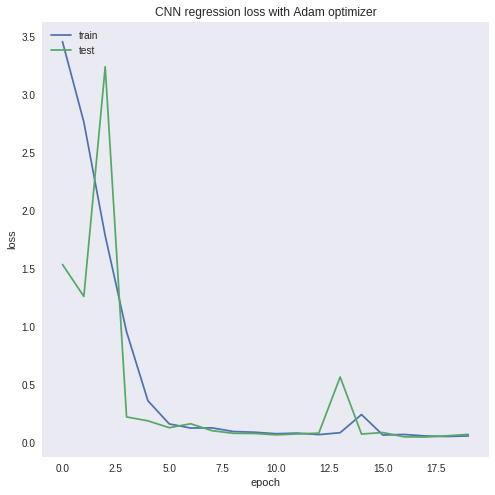

300/300 [==============================] - 2s 5ms/step
Cross-entropy loss for test dataset:  [0.08833434174458187, 0.023889917035897573]


In [38]:
plt.figure(figsize=(8,8))
plt.plot(history_encoder.history['loss'])
plt.plot(history_encoder.history['val_loss'])
plt.title('CNN regression loss with Adam optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(None)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

X_test = X_test.reshape((300, IMAGE_SIZE, IMAGE_SIZE, 1))
test_loss =  model_denoiser.evaluate(X_test_noisy, X_test)
print("Cross-entropy loss for test dataset: ",test_loss)




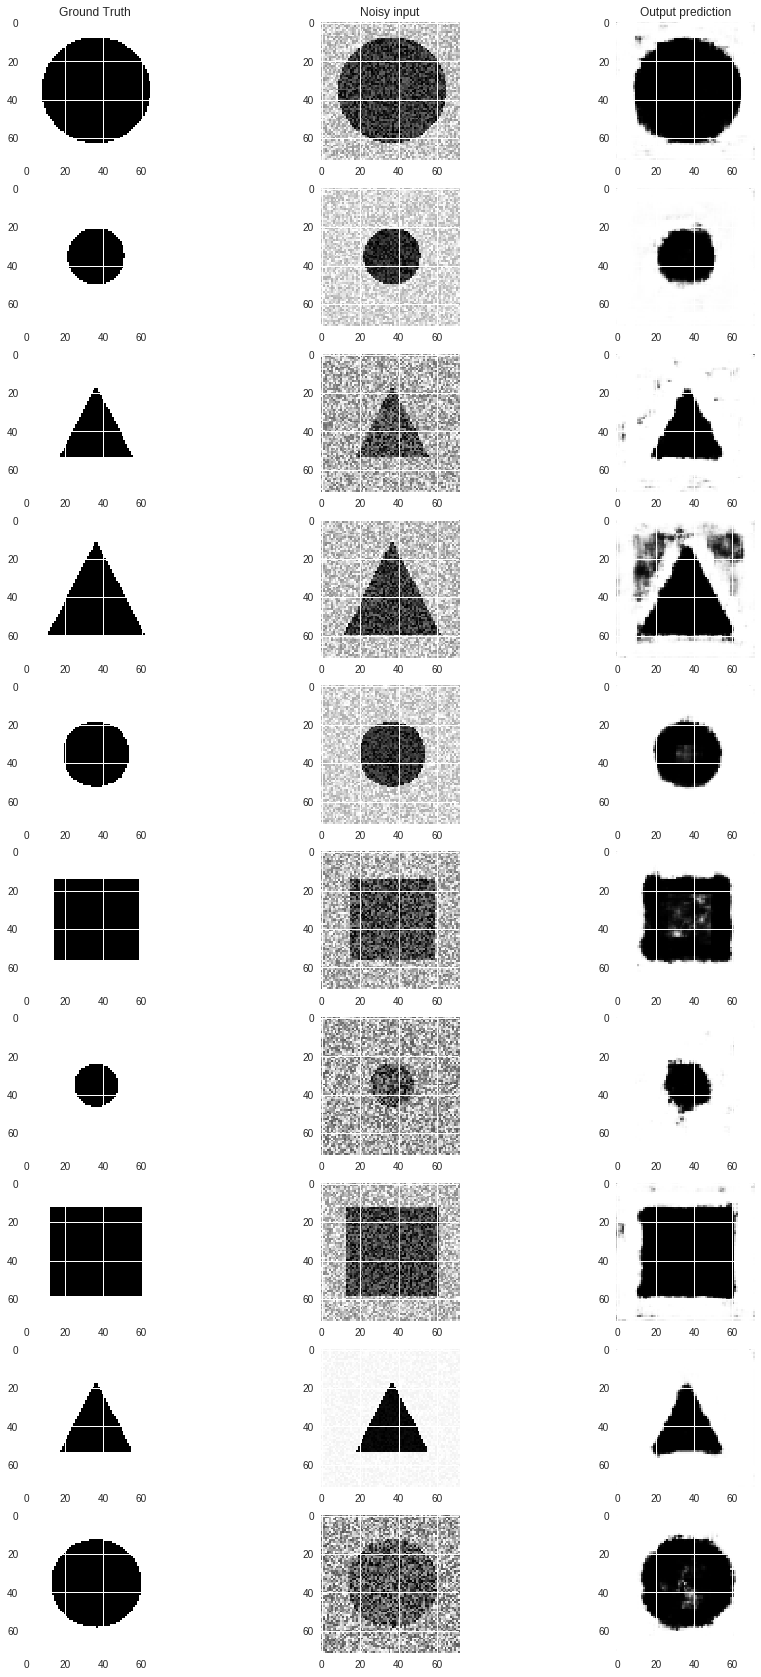

In [37]:
n = 10
pred = model_denoiser.predict(X_test_noisy)
fig, ax = plt.subplots(n, 3, figsize=(15,30))
for i in range(n):
  rd = np.random.randint(len(X_test_noisy))
  ax[i,0].imshow(X_test[rd].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
  ax[i,1].imshow(X_test_noisy[rd].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
  ax[i,2].imshow(pred[rd].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
  if i==0:
    ax[i,0].set_title('Ground Truth')
    ax[i,1].set_title('Noisy input')
    ax[i,2].set_title('Output prediction')
  
plt.show()

### Comments

Our trained network predicts a noise-free shape given the noisy input. The loss converges to really small values which prooves the convergence of our neural network's parameters. In many cases, we recover the right shape or similar shape to the ground truth image.
However, sometimes the encoder fails to clear completely the residual pixels in the background, but still manages to separate the shape from the residues.